In [3]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import sklearn as skl
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale

In [4]:
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import numpy as np
X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(X)
distances, indices = nbrs.kneighbors(X)
indices

array([[0],
       [1],
       [2],
       [3],
       [4],
       [5]])

In [5]:
indices.reshape(1,6)[0]

array([0, 1, 2, 3, 4, 5])

In [6]:
distances

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])

IC* Algorithm with Missing Data

SkeletonFinder

PairwiseConditionalIndependenceTester
    - variables to compare
    - conditioning set
    
    independent(cutoff?): boolean

ImmoralitiesFinder

DataSplitter

DataGenerator

ConditionalIndependenceTester

In [7]:
df = pd.DataFrame({ 'hello': ['a','b','c'], 'hi': ['1', '2', '3']})

In [8]:
df.iloc[:1]

,hello,hi
0,a,1


In [9]:
df.at[:,'hi'] = ['5','6','7']
df

,hello,hi
0,a,5
1,b,6
2,c,7


In [10]:
df

,hello,hi
0,a,5
1,b,6
2,c,7


In [11]:
df.iloc[:int(df.shape[0] / 2)]

,hello,hi
0,a,5


In [12]:
df.iloc[int(df.shape[0] / 2):]

,hello,hi
1,b,6
2,c,7


In [13]:
df.iloc[int(df.shape[0] / 2):df.shape[0]]

,hello,hi
1,b,6
2,c,7


In [14]:
df.iloc[[1,1]]

,hello,hi
1,b,6
1,b,6


In [15]:
int(3 / 2)

1

In [16]:
df['hi'].sample(n=df.shape[0])

1    6
2    7
0    5
Name: hi, dtype: object

In [17]:
df[['hi', 'hello']].sample(n=df.shape[0])

,hi,hello
0,5,a
2,7,c
1,6,b


In [18]:
df[['hi', 'hello']].sample(n=df.shape[0])

,hi,hello
1,6,b
2,7,c
0,5,a


In [19]:
pd.concat([df[['hi']], df[['hello']]], axis=1)

,hi,hello
0,5,a
1,6,b
2,7,c


In [20]:
df = pd.DataFrame({'hi': np.random.normal(loc=0, scale=1.0, size=1000), 'hello': np.random.normal(loc=0, scale=1.0, size=1000), 'ho': np.random.normal(loc=0, scale=1.0, size=1000)})

In [21]:
df.sample()

,hi,hello,ho
441,-0.180949,-1.559593,3.084441


In [22]:
class ConditionallyIndependentDataGenerator:
    """
        Main idea is to generate a data set that satisfies X _||_ Y | Z: X is independent of
        Y given Z, which is satisfied if f(x|z)f(y|z)f(z) = f(x,y,z). We're able to do this
        by splitting the data set into two. For the first data set, find the 1-Nearest 
        Neighbors from the second data set using z. Then pick the Y from the second data set 
        and set that as the new Y for the first data set. This amounts to sampling f(y | z).
        We already have f(x|z) and f(z) in the first data set, so by returning the first data 
        set, we have f(x|z)f(y|z)f(z) = f(x,y,z).
        
        @param data [pandas.DataFrame] Part of the columns are the conditioning_set_names 
            and swappables as columns. 
        
        @param conditioning_set_names [List[String]] List of String names of what we're 
        conditioning on (i.e. Z in the example above). Defaults to empty list.
        
        @param swappables [List[String]] The variable we're copying from half of the data 
        set.
    """
    def __init__(self, data, swappables, conditioning_set_names=[]):
        self.swappables = swappables
        self.conditioning_set_names = conditioning_set_names
        self.data = data
        
        half_length = int(data.shape[0] / 2)
            
        self.data_1 = data.iloc[:half_length].copy()
        self.data_2 = data.iloc[half_length:self.__end_index__()].copy()
        
        assert len(swappables) >= 1
        assert self.data_1.shape[0] == self.data_2.shape[0]
        
    """
        Generates a conditionally independent data set.
        
        @return [pandas.DataFrame] DataFrame with half the length of the original data passed in
        the init method.
    """
    def generate(self):
        columns = self.data_1.columns 
        not_swappables = list(set(columns) - set(self.swappables))
            
        if len(self.conditioning_set_names) == 0:
            # shuffle the swappable part to break dependence between "swappable" and 
            # "not swappable" columns
            
            return pd.concat(
                [
                    self.data_1[not_swappables].reset_index(drop=True),
                    self.data_1[self.swappables]\
                        .sample(n=self.data_1.shape[0]).reset_index(drop=True)
                ],
                axis=1
            )
        
        data_1_cond_set = self.data_1[self.conditioning_set_names].copy()
        data_2_cond_set = self.data_2[self.conditioning_set_names].copy()
    
        nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').\
            fit(data_1_cond_set.values)
        
        _, indices = nbrs.kneighbors(data_2_cond_set.values)
        
        data_2_nearest_neighbors = self.data_2.iloc[indices.reshape(1, indices.shape[0])[0]]
        
        data_1_concatables = self.data_1[not_swappables]
        data_2_concatables = data_2_nearest_neighbors[self.swappables]
        
        return pd.concat(
            [
                data_1_concatables.reset_index(drop=True),
                data_2_concatables.reset_index(drop=True)
            ],
            axis=1
        )
        
    """
        Meant to help enforce equal sizes for the two data sets to make later steps 
        (e.g swapping) easier.
    """
    
    def __end_index__(self):
        if self.data.shape[0] % 2 != 0:
            return self.data.shape[0] - 1
        else: 
            return self.data.shape[0]
        

In [23]:
class ConditionalIndependenceTester:
    """
        @param data [pandas.DataFrame] 
        @param comparables_1 [List[Strings]] List of variable names.
        @param comparables_2 [List[Strings]] List of variable names.
        @param conditioning_set = [List[Strings]] The list of variable names 
            corresponding to the conditioning set.
    """
    def __init__(self, data, comparables_1, comparables_2, conditioning_set=[]):
        self.data = data
        self.comparables_1 = comparables_1
        self.comparables_2 = comparables_2
        self.conditioning_set = conditioning_set
        
        assert len(self.comparables_1) >= 1
        assert len(self.comparables_2) >= 1
        
    """
        Tests the conditional independence X _||_ Y | Z.
        
        X represents comparables_1 param (passed in to the init method).
        Y represents comparables_2 param (passed in to the init method).
        Z represents the conditioning_set (passed in to the init method).
            Could be empty.
            
        @return boolean
    """
    def is_independent(self):
        data_1_length = int(self.data.shape[0] / 3)
        data_1 = self.data.iloc[0:data_1_length].copy()
        data_2 = self.data.iloc[data_1_length:]
        
        cid_generator = ConditionallyIndependentDataGenerator(
            data=data_2, 
            swappables=self.comparables_2
        )
        
        conditionally_indep_data = cid_generator.generate()
        
        data_1['label'] = 1
        conditionally_indep_data['label'] = 0
        
        train_and_test_data = pd.concat([
            data_1,
            conditionally_indep_data
        ])
        
        predictors = list(set(train_and_test_data.columns) - set(['label']))
        
        X = train_and_test_data[predictors].values
        y = train_and_test_data['label']
        
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.5, stratify=y
        )
        
        clf = RandomForestClassifier()
        clf.fit(X_train, y_train)
        return clf.score(X_test, y_test) <= 0.54

In [24]:
def percent_independent(results):
    """
        @param results [List[Boolean]] True if independent, False if dependent
        
        @return percent of true count / results count
    """
    
    return results.sum() / len(results)

In [25]:
def test_a_bunch(func, num_times=1000, size=1000):
    results = []
    
    for i in range(num_times):
        results.append(func(size))
    
    return np.array(results)

In [26]:
def dependent_two_vars(size=1000):
    x = np.random.normal(size=size)
    u = np.random.normal(size=size)
    y = x + u
    uncond_indep_df = pd.DataFrame({'x': x, 'y': y})

    tester = ConditionalIndependenceTester(data=uncond_indep_df, comparables_1=['x'], comparables_2=['y'])
    return tester.is_independent()

In [27]:
def independent_two_vars(size=1000):
    x = np.random.normal(size=size)
    y = np.random.normal(size=size)
    df = pd.DataFrame({'x': x, 'y': y})

    tester = ConditionalIndependenceTester(data=df, comparables_1=['x'], comparables_2=['y'])
    return tester.is_independent()

Test cases:



* $X \perp Y | Z$
    - fork
    - chain
    
* $X \not\perp Y | Z$
    - collider case
    - fork with unobserved confounding
    - chain with unobserved confounding

* Variable type
    - Discrete variables
    - Continuous variables
    - Mix of Discrete and Continuous variables

* Positivity


In [ ]:
percent_independent(test_a_bunch(func=dependent_two_vars, size=10000))

In [321]:
percent_independent(test_a_bunch(func=independent_two_vars, size=10000))

1.0

In [315]:
percent_independent(test_a_bunch(func=dependent_two_vars, size=1000))

0.034

In [316]:
percent_independent(test_a_bunch(func=independent_two_vars, size=1000))

0.917

In [318]:
percent_independent(test_a_bunch(func=dependent_two_vars, size=100))

0.415

In [319]:
percent_independent(test_a_bunch(func=independent_two_vars, size=100))

0.659

In [294]:
dep_two_vars_results.sum()

0

In [28]:
x = np.random.normal(size=1000)
y = np.random.normal(size=1000)
uncond_indep_df = pd.DataFrame({'x': x, 'y': y})

tester = ConditionalIndependenceTester(data=uncond_indep_df, comparables_1=['x'], comparables_2=['y'])
tester.is_independent()

True

In [29]:
blah.plot.scatter(x='x',y='y')

NameError: name 'blah' is not defined

In [30]:
blah[blah['label'] == 1].plot.scatter(x='x', y='y')

NameError: name 'blah' is not defined

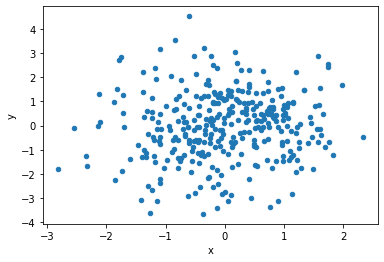

In [224]:
blah[blah['label'] == 0].plot.scatter(x='x', y='y')

In [44]:
class DataPreprocessor:
    NON_ORDINAL_SCALER = 0.707
    
    """
        ConditionalIndependenceTester uses Nearest Neighbor methods. In
        order for them to work, we would need to represent our data as a
        vector of numeric values (i.e. strings are not allowed). 
        
        One property we'd like to have is for each variable to have the 
        same strength of influence on distance measures, such as the 
        Euclidean distance.
        
        Here's the strategy that is being used here to implement that:
        
        For continuous data, we will scale the data between 0 and 1.
        
        For non-ordinal categorical data, we could dummify / one-hot-encode 
        them. Once they are one-hot encoded, we could scale the
        one-hot-encoding by 1/sqrt(2) so that categorical data weighs the 
        same as a continuous variable.
        
        Example:
        
        Let's say we have A as a categorical variable Race with possible
        values [Black, Asian, White], and let's say B represents the Grade
        on a test -- a continuous variable between 0 and 100.
        
        For var A:
        
        We dummify Race so that its represented by three dummy variables:
        Race_Black, Race_Asian, Race_White.
        
        If a person is Black, then they would be represented with a vector 
        of [1, 0, 0], where the indexes correspond to the dummies in order.
        We re-scale this to [1/sqrt(2), 0] =~ [0.71, 0].
        
        For var B:
        
        We re-scale B to [0,1] so that 18 corresponds with 0, and 45 
        corresponds with 45.
        
        Let's do some comparisons from a Euclidean distance point of view:
        
        Scenario 1: 
        
        Let's have two individuals: same Race but different Grade, e.g. 
        a White person with Grade 0 vs. a White person with Grade 100.
        
        The columns are ordered as follows: Race_Black, Race_Asian, 
        Race_White, Grade.
        
        White person with Grade 0 will be represented as [-0.7, -0.7, 0.7, -1]
        while a White person with Grade 100 is represented as [-0.7, -0.7, 0.7, 1].
        
        Euclidean distance would be:
            sqrt(
                (-0.7 - -0.7)^2 + 
                (-0.7 - -0.7)^2 + 
                (0.7 - 0.7)^2 + 
                (-1 - 1)^2
            ) = 2
            
        Scenario 2:
        
        Let's have two individuals: same Grade but different Race, e.g. 
        a White person with Grade 100 vs. a Black person with Grade 100.
    
        White person with Grade 100 will be represented as [-0.7, -0.7, 0.7, 1]
        while a Black person with Grade 100 is represented as [-0.7, 0.7, -0.7, 1].
        
        Euclidean distance would be:
            sqrt(
                (-0.7 - -0.7)^2 + 
                (-0.7 - 0.7)^2 + 
                (0.7 - -0.7)^2 + 
                (1 - 1)^2
            ) = 2*(1.4)^2 
             ~= 2
            
        As we can see from the two scenarios, the scaling factor enables us to make
        each variable have the same impact on the Euclidean distance metric as other
        variables, regardless of the variable being discrete or continuous.
        
        @param data [pandas.DataFrame] Each column represents data from a variable.
        
    """
    def __init__(self, data):
        self.data = data
        
    def preprocess(self):
        self._categorize_columns()
        self._dummify_non_ordinal_columns()
        self._scale_non_ordinal_columns()
        self._scale_ordinal_columns()
        
        return pd.concat(
            [
                self.non_ordinal_columns,
                self.ordinal_columns
            ],
            axis=1
        )
        
    def _categorize_columns(self):
        self.ordinal_column_names = []
        self.non_ordinal_column_names = []
        
        for column_name in self.data.columns:
            kind = self.data[column_name].dtype.kind
            
            if kind == 'O':
                self.non_ordinal_column_names.append(column_name)
            else:
                self.ordinal_column_names.append(column_name)
        
        

    def _dummify_non_ordinal_columns(self):
        self.non_ordinal_columns = pd.DataFrame()
        
        for non_ordinal_column_name in self.non_ordinal_column_names:
            self.non_ordinal_columns = pd.concat(
                [
                    self.non_ordinal_columns,
                    pd.get_dummies(
                        self.data[non_ordinal_column_name], 
                        prefix=non_ordinal_column_name, 
                        prefix_sep=' | '
                    )
                ],
                axis=1
            )
    
    def _scale_non_ordinal_columns(self):
        self.non_ordinal_columns = self.non_ordinal_columns * self.NON_ORDINAL_SCALER
        
    
    def _scale_ordinal_columns(self):
        self.ordinal_columns = \
            pd.DataFrame(
                minmax_scale(
                    self.data[self.ordinal_column_names]
                ), 
                columns=self.ordinal_column_names
            )

In [45]:
sample_df = pd.DataFrame({'categorical_non_ordinal': ['red', 'white', 'blue'], 'continuous': np.random.normal(size=3)})
sample_df

,categorical_non_ordinal,continuous
0,red,-0.271738
1,white,-0.925739
2,blue,-1.134635


In [46]:
DataPreprocessor(data=sample_df).preprocess()

,categorical_non_ordinal | blue,categorical_non_ordinal | red,categorical_non_ordinal | white,continuous
0,0.000,0.707,0.000,1.000000
1,0.000,0.000,0.707,0.242087
2,0.707,0.000,0.000,0.000000


In [350]:
minmax_scale(sample_df[['continuous']])

array([[0.        ],
       [0.45151568],
       [1.        ]])

In [345]:
pd.get_dummies(sample_df['categorical_non_ordinal'], prefix='Blah', prefix_sep=' | ')

,Blah | blue,Blah | red,Blah | white
0,0,1,0
1,0,0,1
2,1,0,0


In [346]:
(pd.get_dummies(sample_df['categorical_non_ordinal'], prefix='Blah', prefix_sep=' | ') == 0) * -1

,Blah | blue,Blah | red,Blah | white
0,-1,0,-1
1,-1,-1,0
2,0,-1,-1


In [339]:
sample_df['categorical_non_ordinal'].dtype

['__bool__',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__mul__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rmul__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'alignment',
 'base',
 'byteorder',
 'char',
 'descr',
 'fields',
 'flags',
 'hasobject',
 'isalignedstruct',
 'isbuiltin',
 'isnative',
 'itemsize',
 'kind',
 'metadata',
 'name',
 'names',
 'ndim',
 'newbyteorder',
 'num',
 'shape',
 'str',
 'subdtype',
 'type']

In [340]:
sample_df['categorical_non_ordinal'].dtype.kind

'O'

In [342]:
sample_df['continuous'].dtype.kind

'f'

In [232]:
tester = ConditionalIndependenceTester(data=df, comparables_1=['hi'], comparables_2=['hello'])
tester.is_independent()

0.5435435435435435

In [226]:
tester = ConditionalIndependenceTester(data=df, comparables_1=['hi'], comparables_2=['hello'], conditioning_set=['ho'])
tester.is_independent()

,hi,hello,ho,label
0,-0.133639,1.598901,-0.079050,1
1,-0.411727,-0.684785,0.103084,1
2,-0.008864,0.261622,-0.824324,1
3,0.930386,1.148742,-0.623888,1
4,-2.078397,0.325876,0.363324,1
...,...,...,...,...
328,-1.040957,0.278325,-0.343993,0
329,-0.222976,0.324373,1.316642,0
330,1.347934,-1.959386,-1.185716,0
331,-0.015295,-0.294935,2.146857,0


In [ ]:
class Pair